In [11]:
import numpy as np
import torch
import torch.nn as nn
import sys

sys.path.append("../../")
from vi_rnn.vae import VAE
from vi_rnn.train import train_VAE
from torch.utils.data import DataLoader
from vi_rnn.datasets import Reaching, Reaching_Teacher
from py_rnn.model import RNN, predict
from py_rnn.train import train_rnn
from py_rnn.train import save_rnn, load_rnn
from vi_rnn.utils import *
import matplotlib.pyplot as plt
from vi_rnn.saving import save_model, load_model
from py_rnn.default_params import get_default_params

%matplotlib inline

In [12]:
train_teacher = False  # load already trained teacher model
data_dir = "../../data/student_teacher/"  # store inferred model
model_dir = "../../models/students/"  # store teacher RNN
cuda = True  # toggle if GPU is available

In [13]:
# initialise teacher RNN
model_params, training_params = get_default_params(n_rec=60)
training_params["n_epochs"] = 5000
training_params["l2_rates_reg"] = 0.1
rnn_reach = RNN(model_params)

# initialise teacher RNN's task
task_params_teacher = {
    "onset": [25, 26],  # time till target stimulus onset (uniform between)
    "trial_len": 150,  # trial duration
    "stim_dur": [25, 26],  # target stimulus duration
    "n_stim": 8,  # number of stimuli locations
}
reaching = Reaching(task_params_teacher)
stimulus, target, loss_mask = reaching[1]

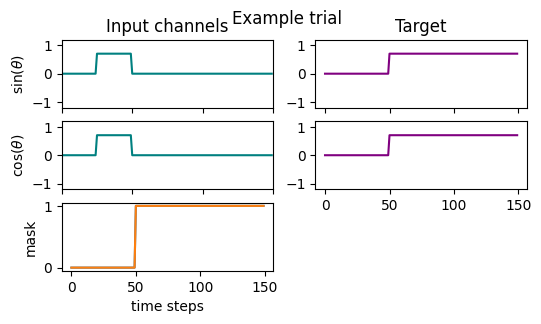

In [14]:
# Plot an example trial for teacher RNN
fig, axs = plt.subplots(3, 2, figsize=(6, 3))
fig.suptitle("Example trial")
axs[0, 0].set_title("Input channels")
axs[0, 1].set_title("Target")
axs[0, 0].set_ylabel(r"$\sin(\theta)$")
axs[1, 0].set_ylabel(r"$\cos(\theta)$")
axs[2, 0].set_ylabel("mask")

for i in range(2):
    axs[i, 0].plot(stimulus[:, i], color="teal")
    axs[i, 0].set_xlim(0, task_params_teacher["trial_len"])
    axs[i, 0].set_ylim(-1.2, 1.2)
axs[2, 0].plot(loss_mask)
for i in range(2):
    axs[i, 1].plot(target[:, i], color="purple")
    axs[i, 0].set_xlim(0, task_params_teacher["trial_len"])
    axs[i, 1].set_ylim(-1.2, 1.2)
    axs[i, 0].set_xticklabels([])
axs[0, 1].set_xticklabels([])
axs[2, 1].set_xlabel("time steps")
axs[2, 0].set_xlabel("time steps")
fig.delaxes(axs[2, 1])

In [15]:
# train or load teacher RNN
if train_teacher:
    losses, reg_losses = train_rnn(
        rnn_reach, training_params, reaching, sync_wandb=False
    )
    save_rnn(
        data_dir + "reach_rnn_new",
        rnn_reach,
        model_params,
        task_params_teacher,
        training_params,
    )
else:
    rnn_reach, model_params, task_params_teacher, training_params = load_rnn(
        data_dir + "reach_rnn"
    )

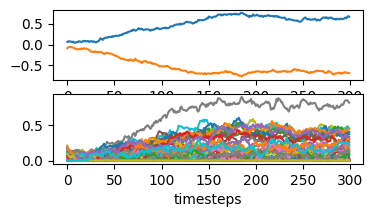

In [16]:
# plot example output
rates, pred = predict(rnn_reach, torch.zeros(300, 2))
fig, axs = plt.subplots(2, figsize=(4, 2))
axs[0].plot(pred[0, :, :])
axs[1].set_xlabel("timesteps")
axs[1].plot(rnn_reach.rnn.nonlinearity(torch.from_numpy(rates[0])));

In [17]:
# Extract weights
U, V, B = extract_orth_basis_rnn(rnn_reach)
I = rnn_reach.rnn.w_inp.detach()

In [18]:
# Generate data using teacher RNN, used for training student RNN
task_params = {
    "dur": 250,
    "n_trials": 800,
    "name": "Sine",
    "n_neurons": rnn_reach.rnn.N,
    "out": "currents",
    "w": 0.1,
    "R_x": 0.05,
    "R_z": 0.05,
    "r0": 0,
    "sim_v": False,
    "non_lin": nn.ReLU(),
}
task_params_teacher["trial_len"] = task_params["dur"]
task = Reaching_Teacher(task_params, task_params_teacher, U, V, B, I, decay=0.9)

torch.Size([800, 2, 250])


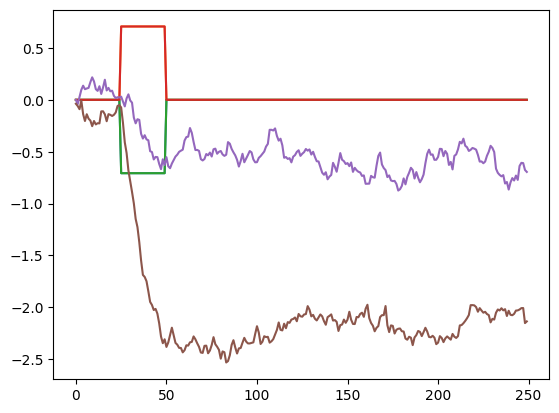

In [19]:
ti = 3
plt.plot(task.stim[ti].T)
plt.plot(task.v[ti].T)
plt.plot(task.latents[ti].T)

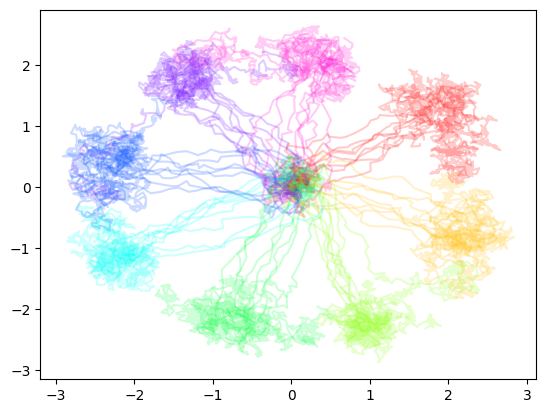

In [20]:
# Plot example latents of teacher RNN
fig, ax = plt.subplots()
prop_cycle = [plt.cm.hsv(i) for i in np.arange(0, 1, 1 / 8)]
ax.set_prop_cycle("color", prop_cycle)
for tr_i in range(8 * 8):
    latent_code = task.latents[tr_i]
    stim = task.stim[tr_i]
    ax.plot(latent_code[0], latent_code[1], alpha=0.2)
    ax.scatter(stim[0, 50], stim[1, 50])

In [ ]:
# Initialise VI / student setup

dim_z = 2
dim_N = task_params["n_neurons"]
dim_x = task_params["n_neurons"]
dim_u = 2
bs = 10
cuda = True
n_epochs = 200
wandb = False

# initialise prior
prior_params = {
    "transition": "low_rank",
    "observation": "one_to_one",
    "train_noise_x": True,
    "train_noise_z": True,
    "train_noise_z_t0": True,
    "init_noise_z": 0.1,
    "init_noise_z_t0": 1,
    "init_noise_x": task_params["R_x"],
    "noise_z": "full",
    "noise_x": "diag",
    "noise_z_t0": "full",
    "activation": "relu",
    "decay": 0.7,
    "readout_from": task_params["out"],
    "train_obs_bias": False,
    "train_obs_weights": False,
    "train_neuron_bias": True,
    "weight_dist": "uniform",
    "initial_state": "trainable",
    "obs_nonlinearity": "identity",
    "obs_likelihood": "Gauss",
    "simulate_input": True,
}


training_params = {
    "lr": 1e-3,
    "lr_end": 1e-5,
    "opt_eps": 1e-8,
    "n_epochs": n_epochs,
    "grad_norm": 0,
    "eval_epochs": 50,
    "batch_size": bs,
    "cuda": cuda,
    "smoothing": 20,
    "freq_cut_off": 10000,
    "k": 64,
    "loss_f": "opt_smc",
    "resample": "systematic",  # , multinomial or none"
    "run_eval": True,
    "smooth_at_eval": False,
    "init_state_eval": "posterior_sample",
}


VAE_params = {
    "dim_x": dim_x,
    "dim_z": dim_z,
    "dim_u": dim_u,
    "dim_N": dim_N,
    "rnn_params": prior_params,
}
vae = VAE(VAE_params)

In [24]:
task

In [ ]:
# Train
train_VAE(
    vae,
    training_params,
    task,
    sync_wandb=wandb,
    out_dir=model_dir[:-1],
    fname=None,
    store_train_stats=False,
)

In [ ]:
save_model(vae, training_params, task_params, name=model_dir + "reach_vae_new2")